In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
from scipy.special import expit

In [2]:
data = pd \
    .read_csv('data/neural_network.txt', names=['x1', 'x2', 'y']) \
    .sample(frac=1)
data.reset_index(inplace=True, drop=True)

for column in data.columns:
    if column == 'y':
        continue
    data[column] = (data[column] - data[column].mean()) / data[column].std()
    
print(data.describe())
data.head()

                 x1            x2           y
count  1.180000e+02  1.180000e+02  118.000000
mean   3.010774e-17 -6.821286e-17    1.508475
std    1.000000e+00  1.000000e+00    0.502060
min   -1.781621e+00 -1.833294e+00    1.000000
25%   -8.595503e-01 -8.417365e-01    1.000000
50%   -1.230541e-01  5.840087e-02    2.000000
75%    8.540982e-01  8.917119e-01    2.000000
max    2.045934e+00  1.781262e+00    2.000000


,x1,x2,y
0,-1.781621,0.248254,2
1,0.480055,-0.792510,1
2,-0.343416,-1.115997,1
3,-1.607637,-0.848769,2
4,-0.076661,-1.130062,1


In [3]:
unique = pd.unique(data['y'])
counter = 0
output_to_modeled = dict()
modeled_to_real = dict()
for unique_output in unique:
    output_to_modeled[unique_output] = counter
    modeled_to_real[counter] = unique_output
    data.loc[data['y'] == unique_output, 'y'] = counter
    counter = counter + 1

output_layer_size=counter

del counter
del unique

print('output_layer_size', output_layer_size)
print('output_to_modeled', output_to_modeled)
print('modeled_to_real', modeled_to_real)

data.head()

output_layer_size 2
output_to_modeled {2: 0, 1: 1}
modeled_to_real {0: 2, 1: 1}


,x1,x2,y
0,-1.781621,0.248254,0
1,0.480055,-0.792510,1
2,-0.343416,-1.115997,1
3,-1.607637,-0.848769,0
4,-0.076661,-1.130062,1


In [4]:
def draw_train_set(data):
    ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red')
    data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

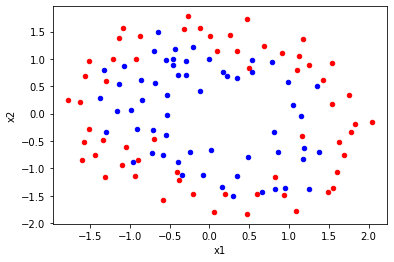

In [5]:
draw_train_set(data)

In [77]:
def extract(data, start, end):
    m = data.shape[0]
    view = data[start:(end - 1)]
    
    dropped_view = view
    if 'y' in data.columns:
        dropped_view = dropped_view.drop('y', axis=1)
    if 'y^' in data.columns:
        dropped_view = dropped_view.drop('y^', axis=1)
    X = dropped_view.to_numpy()
    y = None
    if 'y' in data.columns:
        y = view['y'].to_numpy().reshape(view.shape[0], 1)
    return X, y

def extract_thetas(theta, X, hidden_layer_sizes, output_layer_size):
    n = X.shape[1]
    
    Thetas = []
    
    offset = 0
    last_layer_size = n
    next_offset = 0
    for hidden_layer_size in hidden_layer_sizes:
        offset = next_offset
        next_offset = offset + hidden_layer_size * (last_layer_size + 1)
        Thetas.append(theta[offset:next_offset].reshape(hidden_layer_size, last_layer_size + 1))
        last_layer_size = hidden_layer_size
    offset = next_offset
    next_offset = offset + output_layer_size * (last_layer_size + 1)
    Thetas.append(theta[offset:next_offset].reshape(output_layer_size, last_layer_size + 1))
    
    return Thetas

def compute_a_matrix(X, hidden_layer_sizes, Thetas):
    m = X.shape[0]
    
    A = [np.concatenate((
        np.ones((m, 1)),
        X
    ), axis=1)]
    for i in range(1, len(hidden_layer_sizes) + 2):
        z = np.matmul(A[i - 1], Thetas[i - 1].T)
        a = np.concatenate((
                np.ones((m,1)),
                expit(z)
        ), axis=1)
        A.append(a)
    
    return A

def compute_y_matrix(X, y):
    m = X.shape[0]
    Y = np.zeros((m, output_layer_size))
    for i in range(0, m):
        Y[i, y[i,0]] = 1
    return Y

def compute_h_matrix(A):
    H = A[-1][:, 1:]
    return H
    
def cost_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size):
    # Note: np.multiply performs element-wise multiplication instead of matrix multiplication
    # Note: np.matmul performs matrix multiplication
    # Note: expit is the sigmoid function
    
    m = X.shape[0]
    
    Thetas = extract_thetas(theta, X, hidden_layer_sizes, output_layer_size)
    A = compute_a_matrix(X, hidden_layer_sizes, Thetas)
    H = compute_h_matrix(A)
    Y = compute_y_matrix(X, y)
    
    J = 0
    for i in range(0, output_layer_size):
        yit = Y[:, i]
        hi = H[:, i]
        J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
        
    reg = 0
    for Theta in Thetas:
        view = Theta[:, 1:]
        reg = reg + np.sum(np.multiply(view, view))
    
    J = (J + ((lamb / 2) * reg)) / m
        
    return J

def gradient_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size):
    m = X.shape[0]
    
    Thetas = extract_thetas(theta, X, hidden_layer_sizes, output_layer_size)    
    A = compute_a_matrix(X, hidden_layer_sizes, Thetas)
    H = compute_h_matrix(A)
    Y = compute_y_matrix(X, y)
    
    D = [None] * (len(hidden_layer_sizes) + 2)
    D[len(hidden_layer_sizes) + 1] = H - Y
    for i in range(len(hidden_layer_sizes), 0, -1):
        D[i] = np.matmul(D[i + 1], Thetas[i])
        D[i] = np.multiply(np.multiply(D[i], A[i]), 1 - A[i])
        D[i] = D[i][:, 1:]
    
    Delta = []
    for i in range(0, len(hidden_layer_sizes) + 1):
        Delta.append(np.matmul(D[i + 1].T, A[i]))
        
    Theta_Grads = []
    for i in range(0, len(hidden_layer_sizes) + 1):
        t = np.concatenate((
            np.zeros((Thetas[i].shape[0], 1)),
            Thetas[i][:, 1:]
        ), axis=1)
        Theta_Grads.append((Delta[i] + lamb * t) / m)
    
    to_concatenate = []
    for i in range(0, len(hidden_layer_sizes) + 1):
        to_concatenate.append(Theta_Grads[i].reshape( Theta_Grads[i].shape[0] * Theta_Grads[i].shape[1] ))
    
    return np.concatenate(to_concatenate)

def solve(X, y, lamb, hidden_layer_sizes, output_layer_size):
    n = 0
    last_layer_size = X.shape[1]
    for hidden_layer_size in hidden_layer_sizes:
        n = n + hidden_layer_size * (last_layer_size + 1)
        last_layer_size = hidden_layer_size
    n = n + output_layer_size * (last_layer_size + 1)
    
    result = optimize.minimize(
        lambda theta: cost_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
        jac=lambda theta: gradient_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
        x0=np.random.rand(n),
        method='BFGS')
    return result.x.reshape(n, 1)

def predict(X, theta, hidden_layer_sizes, output_layer_size):
    Thetas = extract_thetas(theta, X, hidden_layer_sizes, output_layer_size)
    A = compute_a_matrix(X, hidden_layer_sizes, Thetas)
    H = compute_h_matrix(A)
    
    yh = H.argmax(axis=1)
    return yh

def model_border(X, theta, hidden_layer_sizes, output_layer_size, sensitivity=0.1):
    Thetas = extract_thetas(theta, X, hidden_layer_sizes, output_layer_size)
    A = compute_a_matrix(X, hidden_layer_sizes, Thetas)
    H = compute_h_matrix(A)
    yh = H.max(axis=1)
    return (yh < (0.5 + sensitivity)) & (yh > (0.5 - sensitivity))
    

def accuracy(X, y, theta, hidden_layer_sizes, output_layer_size):
    return np.sum((y.reshape(X.shape[0]) == predict(X, theta, hidden_layer_sizes, output_layer_size)).astype(int)) / X.shape[0]

def f1score(X, y, theta, hidden_layer_sizes, output_layer_size):
    yh = predict(X, theta, hidden_layer_sizes, output_layer_size)
    y = y.reshape(X.shape[0])
    tp = np.sum(np.logical_and(yh == 1, y == 1).astype(int))
    fp = np.sum(np.logical_and(yh == 1, y == 0).astype(int))
    fn = np.sum(np.logical_and(yh == 0, y == 1).astype(int))
    return tp / (tp + ((fp + fn) / 2))

def check_gradient_inner(n, cost_fn, gradient_fn):
    EPSILON = 1e-5
    theta = np.random.rand(n)
    result = np.zeros((n,))
    for i in range(0, n):
        theta[i] = theta[i] + EPSILON
        cost_plus = cost_fn(theta)
        theta[i] = theta[i] - 2 * EPSILON
        cost_minus = cost_fn(theta)
        theta[i] = theta[i] + EPSILON
        estimated_grad = (cost_plus - cost_minus) / (2 * EPSILON)
        real_grad = gradient_fn(theta)
        result[i] = (estimated_grad - real_grad[i]) / real_grad[i]
    return result

def check_gradient(data, lamb, hidden_layer_sizes, output_layer_size):
    m = data.shape[0]
    X, y = extract(data, 0, m + 1)
    
    n = 0
    last_layer_size = X.shape[1]
    for hidden_layer_size in hidden_layer_sizes:
        n = n + hidden_layer_size * (last_layer_size + 1)
        last_layer_size = hidden_layer_size
    n = n + output_layer_size * (last_layer_size + 1)
    
    return check_gradient_inner(
        n,
        lambda theta: cost_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
        lambda theta: gradient_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
    )

def select_model(data, output_layer_size, max_p):
    m = data.shape[0]
    n = data.shape[1]
    
    Xtrain, ytrain = extract(data, 0, math.ceil(m*0.8))
    Xcv, ycv = extract(data, math.ceil(m*0.8), m + 1)

    df = pd.DataFrame(index=[], columns=['hidden_layers', 'layer_size',
                                                            'cost', 'accuracy', 'f1'])
    index = 0
    for p in range(1, max_p + 1):
        print('PROCESSING p=', p, '/', max_p + 1)
        for s in range(1, 2 * p + 1):
            theta = solve(Xtrain, ytrain, 1, [s] * p, output_layer_size)
            cost = cost_fn(theta, Xcv, ycv, 0, [s] * p, output_layer_size)
            acc = accuracy(Xcv, ycv, theta, [s] * p, output_layer_size)
            f1 = f1score(Xcv, ycv, theta, [s] * p, output_layer_size) 

            df.loc[index] = [p, s, cost, acc, f1]
            index = index + 1
    
    for p in range(1, max_p + 1):
        ax = df[df['hidden_layers'] == p].plot.line(x='layer_size', y='cost', title='hidden_layers=' + str(p))   
        ax = df[df['hidden_layers'] == p].plot.line(x='layer_size', y='accuracy', title='hidden_layers=' + str(p)) 
        ax = df[df['hidden_layers'] == p].plot.line(x='layer_size', y='f1', title='hidden_layers=' + str(p))
    
    df.sort_values(by=['cost'], inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.sort_values(by=['accuracy'], ascending=False, inplace=True)
    return df
    
        

In [72]:
check_gradient(data,0, [3, 3, 3], output_layer_size)

array([ 9.27160798e-10, -1.80000152e-09,  9.86716413e-07,  9.45345579e-09,
        7.88144767e-09,  2.75178729e-07,  1.26334590e-09, -7.79123674e-10,
        3.43743597e-08, -2.45975737e-09, -7.91275058e-09, -4.09253069e-09,
       -1.19223147e-09,  1.61404469e-09, -1.37512846e-09, -5.84856789e-10,
       -4.34411642e-09,  1.28943516e-09,  1.39662266e-09,  1.44311778e-10,
        1.01806650e-09,  9.40110725e-09,  3.01841566e-09, -1.32293347e-08,
        3.27330785e-09, -2.37019870e-10,  8.16813452e-11, -9.32755800e-10,
        3.42295646e-10,  5.57409579e-10, -1.80066491e-10,  8.05258390e-10,
       -4.44340922e-10,  1.67382365e-11,  1.79524886e-11, -2.80135969e-12,
       -5.61705203e-11, -2.16481960e-11,  4.91995577e-11, -5.28004862e-11,
        1.19536488e-10])

In [38]:
check_gradient(data, 1000, [3, 3, 3], output_layer_size)

array([ 5.63532939e-08,  2.09585131e-10,  1.80865506e-10,  9.46756676e-08,
        3.95036633e-11,  2.91812649e-11,  1.23767759e-07,  1.96752410e-10,
        6.52145902e-11, -1.17181171e-08, -2.45479102e-11,  4.31753264e-11,
        2.02845913e-10,  4.65893218e-08,  1.24165422e-11,  1.07744617e-10,
        7.42063371e-11,  4.82499988e-09,  1.68643469e-10, -1.18306484e-11,
       -3.62621068e-11, -6.06973700e-09,  3.36026741e-10, -5.13660074e-11,
       -8.83657979e-10,  1.87919557e-09,  1.98942002e-11,  8.30847816e-11,
        2.13982989e-11,  2.89926378e-09,  1.04192499e-09,  1.13052742e-10,
       -7.32964736e-13, -5.63293379e-10,  3.42987587e-11, -1.67301317e-11,
       -1.08775787e-10, -1.05168888e-10,  3.04370312e-10, -5.28753240e-11,
       -7.90666514e-11])

PROCESSING p= 1 / 6
PROCESSING p= 2 / 6
PROCESSING p= 3 / 6
PROCESSING p= 4 / 6
PROCESSING p= 5 / 6


,hidden_layers,layer_size,cost,accuracy,f1
15,3.0,5.0,1.386294,0.565217,0.000000
18,5.0,6.0,1.386294,0.565217,0.000000
16,3.0,3.0,1.386294,0.565217,0.000000
1,2.0,2.0,1.386291,0.565217,0.000000
14,4.0,8.0,1.386294,0.565217,0.000000
13,3.0,4.0,1.386294,0.565217,0.000000
12,5.0,4.0,1.386294,0.565217,0.000000
11,4.0,1.0,1.386293,0.565217,0.000000
10,5.0,3.0,1.386293,0.565217,0.000000
9,3.0,6.0,1.386293,0.565217,0.000000


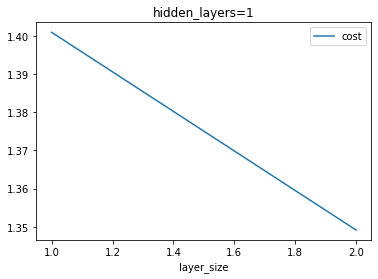

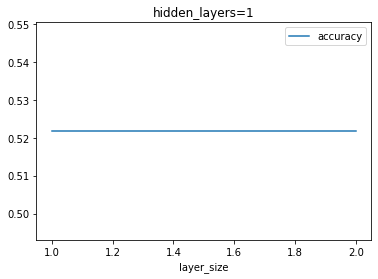

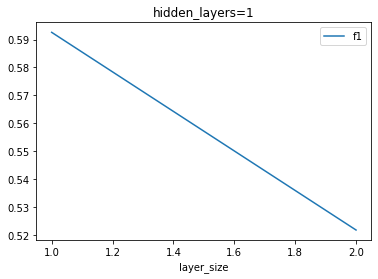

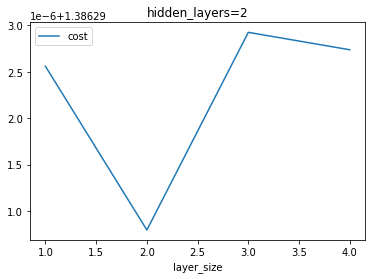

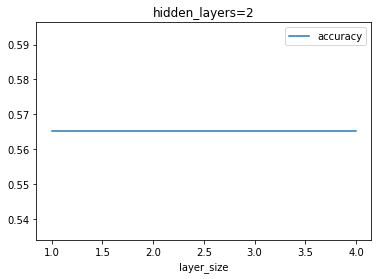

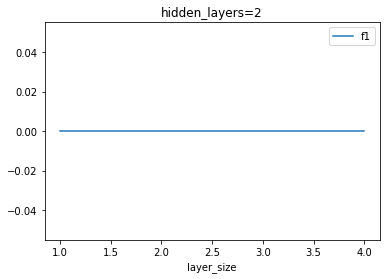

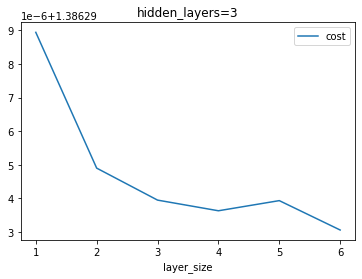

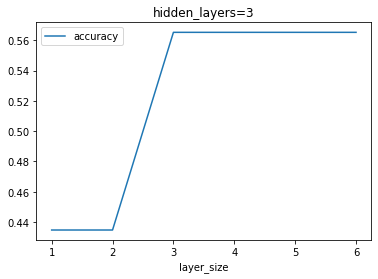

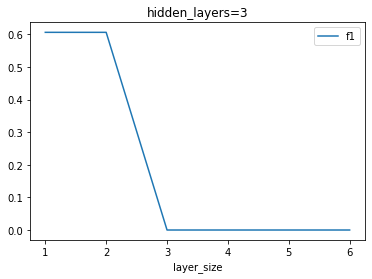

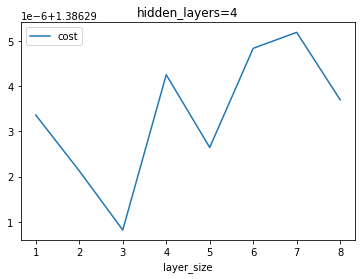

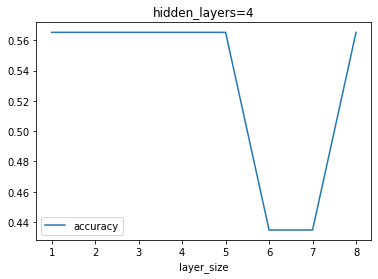

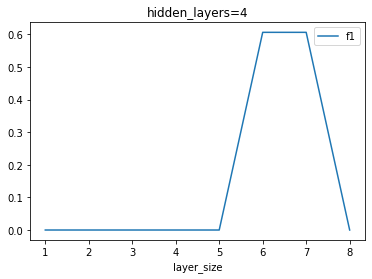

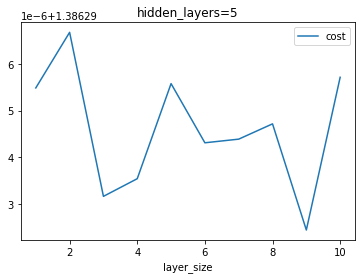

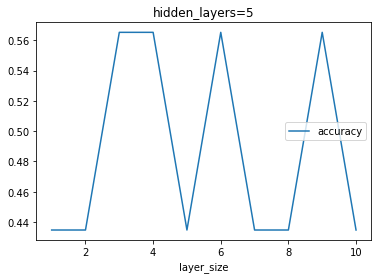

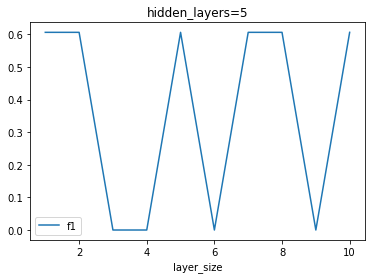

In [39]:
select_model(data, output_layer_size, 5)

In [11]:
hidden_layer_sizes = [2] * 1
X, y = extract(data, 0, data.shape[0] + 1)
Xtrain, ytrain = extract(data, 0, math.ceil(data.shape[0] * 0.8))
Xcv, ycv = extract(data, math.ceil(data.shape[0] * 0.8), data.shape[0] + 1)
theta = solve(X, y, 1, hidden_layer_sizes, output_layer_size)
print(data.columns)
theta

Index(['x1', 'x2', 'y'], dtype='object')


array([[-2.63193104],
       [-1.78309972],
       [-1.65805687],
       [-2.40037316],
       [ 2.09476231],
       [ 1.37180813],
       [-0.71660938],
       [ 1.72701819],
       [ 1.92309092],
       [ 0.7166156 ],
       [-1.72646795],
       [-1.92360767]])

In [73]:
def plot_model(data, theta, hidden_layer_sizes, output_layer_size, step, sensitivity=0.1):
    x1min = data['x1'].min()
    x1max = data['x1'].max()
    x2min = data['x2'].min()
    x2max = data['x2'].max()
    x1count = math.ceil((x1max - x1min) / step)
    x2count = math.ceil((x2max - x2min) / step)
    Xplot = pd.DataFrame(index=range(0, x1count * x2count), columns=['x1', 'x2'], dtype=np.float64)
    for i in range(0, x1count):
        x1 = x1min + step * i
        for j in range(0, x2count):
            x2 = x2min + step * j
            Xplot.loc[i * x1count + j] = [x1, x2]
    X, y = extract(Xplot, 0, Xplot.shape[0] + 1)
    Xplot['y^'] = model_border(X, theta, hidden_layer_sizes, output_layer_size, sensitivity=sensitivity).astype(int)
    ax = Xplot[Xplot['y^'] == 1].plot.scatter(x='x1', y='x2', c='green')
    ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red', ax=ax)
    data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

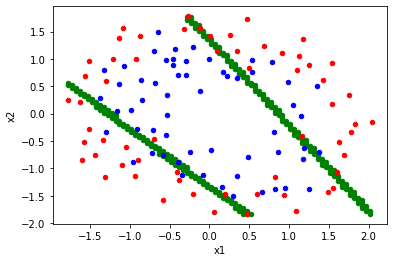

In [81]:
plot_model(data, theta, hidden_layer_sizes, output_layer_size, 0.05, sensitivity=0.01)

In [14]:
def select_lambda(Xtrain, ytrain, Xcv, ycv, hidden_layer_sizes, output_layer_size, begin, end, step):
    m = data.shape[0]
    
    count = math.ceil((end - begin) / step)
    df = pd.DataFrame(index=range(0, count), columns=['lambda', 'cost', 'accuracy', 'f1'])
    
    for i in range(0, count):
        lamb = begin + i * step
        theta = solve(Xtrain, ytrain, lamb, hidden_layer_sizes, output_layer_size)
        cost = cost_fn(theta, Xcv, ycv, 0, hidden_layer_sizes, output_layer_size)
        acc = accuracy(Xcv, ycv, theta, hidden_layer_sizes, output_layer_size)
        f1 = f1score(Xcv, ycv, theta, hidden_layer_sizes, output_layer_size)
        df.loc[i] = [lamb, cost, acc, f1]
        
    df.plot.line(x='lambda', y='cost')
    df.plot.line(x='lambda', y='accuracy')
    df.plot.line(x='lambda', y='f1')
    df.sort_values(by=['cost'], inplace=True)
    print(df)

   lambda      cost  accuracy        f1
0       1  1.349179  0.521739  0.521739
14     15  1.386291  0.565217       0.0
24     25  1.386291  0.565217       0.0
20     21  1.386291  0.565217       0.0
88     89  1.386292  0.565217       0.0
..    ...       ...       ...       ...
29     30  1.386297  0.434783  0.606061
41     42  1.386298  0.434783  0.606061
17     18  1.386298  0.434783  0.606061
36     37  1.386298  0.434783  0.606061
92     93  1.386299  0.434783  0.606061

[99 rows x 4 columns]


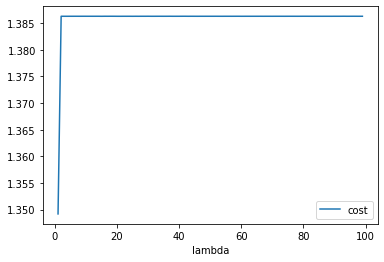

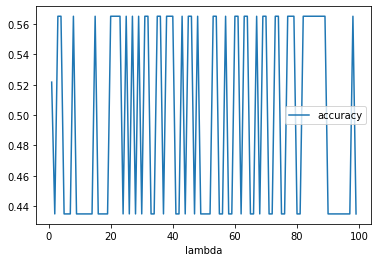

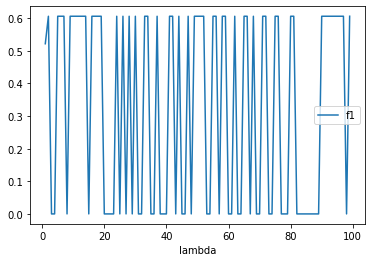

In [15]:
select_lambda(Xtrain, ytrain, Xcv, ycv, hidden_layer_sizes, output_layer_size, 1, 100, 1)

In [16]:
lamb = 1
theta = solve(X, y, lamb, hidden_layer_sizes, output_layer_size)
data['y^'] = predict(X, theta, hidden_layer_sizes, output_layer_size)
theta

array([[-2.40021184],
       [ 2.09463527],
       [ 1.37199439],
       [-2.6323259 ],
       [-1.78298578],
       [-1.65858645],
       [-0.71658663],
       [ 1.92313478],
       [ 1.7266991 ],
       [ 0.7167597 ],
       [-1.92357004],
       [-1.72710053]])

In [19]:
def draw_learning_curve(data, lamb, hidden_layer_sizes, output_layer_size, start=None, end=None):
    df = [] # m, cv, train
   
    start = start or 0
    end = end or data.shape[0]
    
    for m in range(start, end + 1):  
        Xtrain, ytrain = extract(data, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(data, math.ceil(m*0.8), m + 1)
        if ycv.shape[0] < 1:
            continue
        
        theta = solve(Xtrain, ytrain, lamb, hidden_layer_sizes, output_layer_size)
        cost_train = cost_fn(theta, Xtrain, ytrain, 0, hidden_layer_sizes, output_layer_size)
        cost_cv = cost_fn(theta, Xcv, ycv, 0, hidden_layer_sizes, output_layer_size)
        
        df.append([m, cost_cv, cost_train])
            
    df = pd.DataFrame(df, columns=['m', 'cv', 'train'])
    ax = df.plot.line(x='m', y='cv')
    df.plot.line(x='m', y='train', ax=ax)


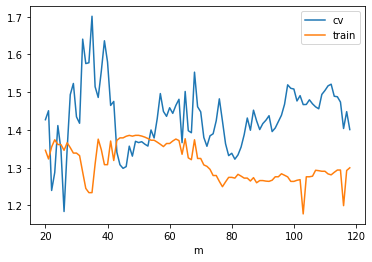

In [20]:
draw_learning_curve(data, lamb, hidden_layer_sizes, output_layer_size, start=20)